# MMSB textbook figures

In [ ]:
# Packages
using DifferentialEquations, Plots, Parameters, LabelledArrays
Plots.gr(fmt=:png)

In [ ]:
# Convenience functions
_mm(x, k=one(x)) = x / (x + k)
_hill(x, k, n) = _mm((x/k)^n)
exprel(x) = ifelse(x≈zero(x), one(x), x / expm1(x))

## Fig 1.7 Collins toggle switch

For Figures 1.7, 7.13, 7.14, 7.15

In [ ]:
#=
model of Collins toggle switch
from Gardiner et al. (2000) Nature 403, pp. 339-342
Figures 1.7, 7.13, 7.14, 7.15
=#

# Object to store the parameters
# Namedtuple also works: p = (a1=3.0, a2=2.5, β=4.0, γ=4.0)
@with_kw struct Collins
    a1 = 3.0
    a2 = 2.5
    β = 4.0
    γ = 4.0
end

# The ODE model
function collins!(du, u, p::Collins, t)
    @unpack a1, a2, β, γ = p
    @unpack s1, s2 = u
    i1 = ifelse(30.0 < t < 40.0, 10.0, 0.0)
    i2 = ifelse(10.0 < t < 20.0, 10.0, 0.0)
    du.s1 = a1 * _hill(1 + i2, s2, β) - s1
    du.s2 = a2 * _hill(1 + i1, s1, γ) - s2
    return du
end

# Time points of sudden change
tstops = [10.0, 20.0, 30.0, 40.0]
# Inittial conditions, time span and parameters
u0 = LVector(s1=0.075, s2=2.5)
p = Collins()
prob = ODEProblem(collins!, u0, 50.0, p)
sol = solve(prob, t_stops=tstops);

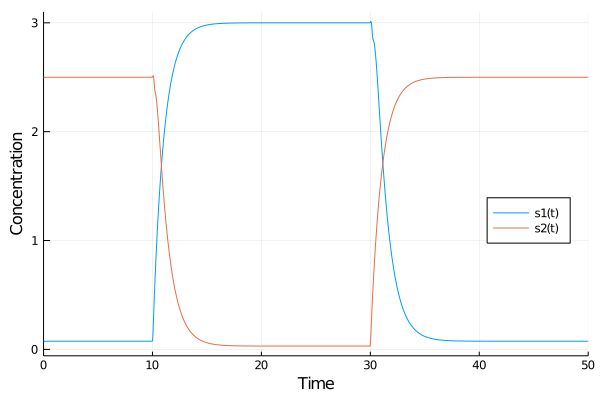

In [8]:
plot(sol, legend=:right, xlabel="Time", ylabel="Concentration")

## Fig 1.9 Hodgkin-Huxley model

In [10]:
"Parameters for Hodgkin-Huxley model"
@with_kw struct HH
    E_N = 55.0       # Reversal potential of Na (mV)
    E_K = -72.0      # Reversal potential of K (mV)
    E_LEAK = -49.0   # Reversal potential of leaky channels (mV)
    G_N_BAR = 120.0  # Max. Na channel conductance (mS/cm^2)
    G_K_BAR = 36.0   # Max. K channel conductance (mS/cm^2)
    G_LEAK = 0.30    # Max. leak channel conductance (mS/cm^2)
    C_M = 1.0        # membrane capacitance (uF/cm^2)
end

function _istim(t)
    if 20.0 < t <= 21.0
        return -6.65
    elseif 60.0 < t <= 61.0
        return -6.83
    else
        return 0.0
    end
end

_ina(u, p::HH, t) = p.G_N_BAR * (u.v - p.E_N) * (u.m^3) * u.h
_ik(u, p::HH, t) = p.G_K_BAR * (u.v - p.E_K) * (u.n^4)
_ileak(u, p::HH, t) = p.G_LEAK * (u.v - p.E_LEAK)

"ODE system of HH model"
function hh!(du, u, p::HH, t)
    @unpack E_N, E_K, E_LEAK, G_N_BAR, G_K_BAR, G_LEAK, C_M = p
    @unpack v, m, h, n = u
    
    mαV = -0.10 * (v + 35)
    mα = exprel(mαV)
    mβ = 4.0 * exp(-(v + 60) / 18.0)

    hα = 0.07 * exp(-(v+60)/20)
    hβ = 1 / (exp(-(v+30)/10) + 1)

    nαV = -0.1 * (v+50)
    nα = 0.1 * exprel(nαV)
    nβ = 0.125 * exp( -(v+60) / 80)
    
    iNa = _ina(u, p, t)
    iK = _ik(u, p, t)
    iLeak = _ileak(u, p, t)
    iStim = _istim(t)
    du.v = -(iNa + iK + iLeak + iStim) / C_M
    du.m = -(mα + mβ) * m + mα
    du.h = -(hα + hβ) * h + hα
    du.n = -(nα + nβ) * n + nα
    return du
end

# Time points of sudden change
tStops = [20.0, 21.0, 60.0, 61.0]

# Initial conditions, time span, and parameters
u0 = LVector(v=-59.8977, m=0.0536, h=0.5925, n=0.3192)
p = HH()

# Define the problem and solve it
prob = ODEProblem(hh!, u0, 100.0, p)
sol = solve(prob, tstops=tStops);

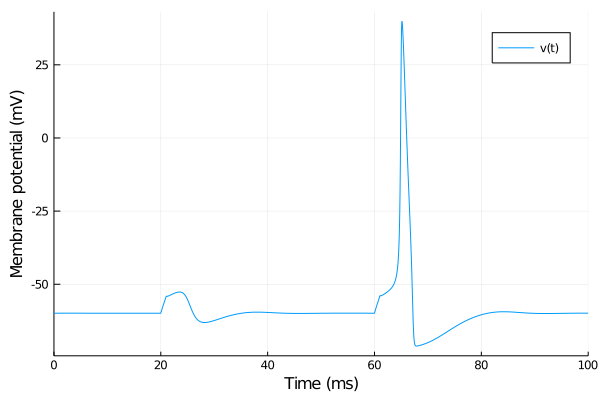

In [11]:
plot(sol, vars=(0, 1),
     ylabel="Membrane potential (mV)", xlabel="Time (ms)")

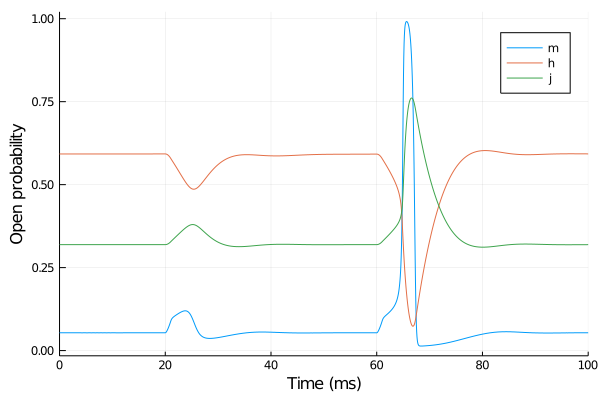

In [12]:
plot(sol, vars=(0, [2, 3, 4]), label=["m" "h" "j"],
     ylabel="Open probability", xlabel="Time (ms)")

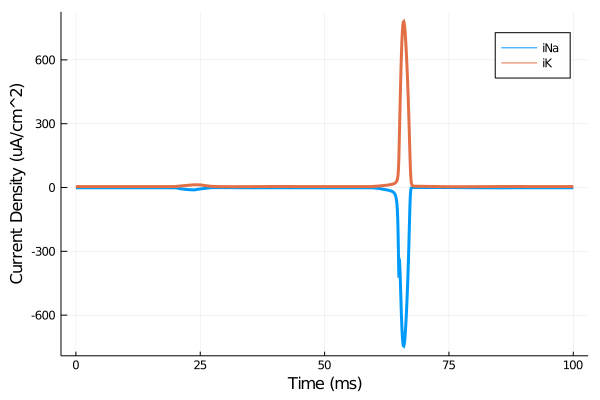

In [16]:
plot(t->_ina(sol(t), p, t), tspan[1], tspan[end], label="iNa", 
     ylabel="Current Density (uA/cm^2)", xlabel="Time (ms)", lw=3)
plot!(t->_ik(sol(t), p, t), tspan[1], tspan[end], label="iK", lw=3)

# Fig 2.04 Exponential decay

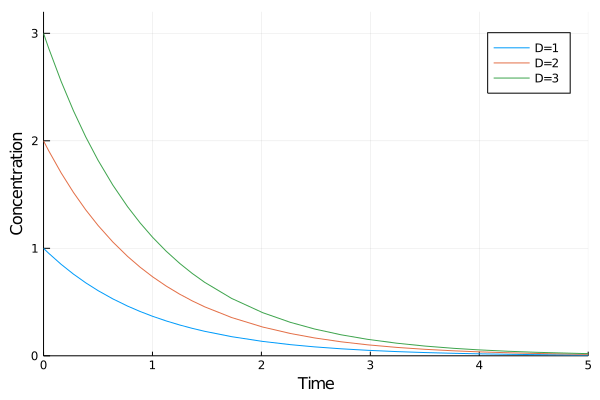

In [1]:
plot([t->exp(-t) t->exp(-2t) t->exp(-3t)], 0.0, 5.0, 
      xlim = (0, 5), ylim=(0, 3.2), xlabel="Time", ylabel="Concentration")

# Fig 2.07 Euler method

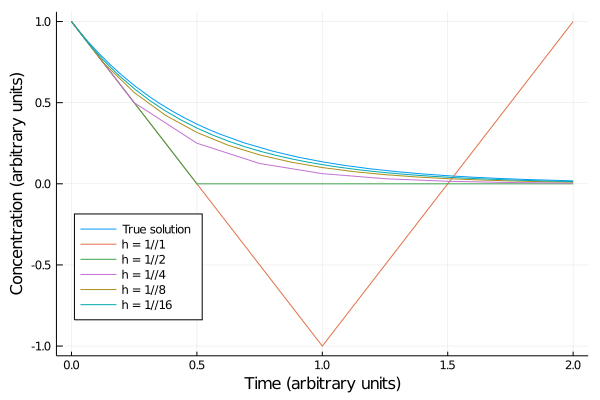

In [7]:
step_euler(u, p, t, h, f) = u + f(u, p, t) * h

fig_27(u, p, t) = p * u

tspan = (0.0, 2.0)
p = -2.0

# Reference solution
plot(x->exp(p*x), tspan[1], tspan[end], lab="True solution", legend=:bottomleft)

for h in (1//1, 1//2, 1//4, 1//8, 1//16)
    ts = range(tspan[1], step=h, stop=tspan[2])
    us = [1.0]  # Initial condition
    u = us[1]
    for t in ts[1:end-1]
        u = step_euler(u, p, t, h, fig_27)
        push!(us, u)
    end
    plot!(ts, us, lab="h = $h")
end

plot!(xlabel="Time (arbitrary units)", ylabel="Concentration (arbitrary units)")

# Fig 2.09 Numerical Simulation of metabolic network

┌ Info: Precompiling DiffEqBiological [eb300fae-53e8-50a0-950c-e21f52c2b7e0]
└ @ Base loading.jl:1260
┌ Warning: The RegularJump interface has changed to be matrix-free. See the documentation for more details.
└ @ DiffEqJump C:\Users\TsengWen-Wei\.julia\packages\DiffEqJump\dTrZP\src\jumps.jl:43


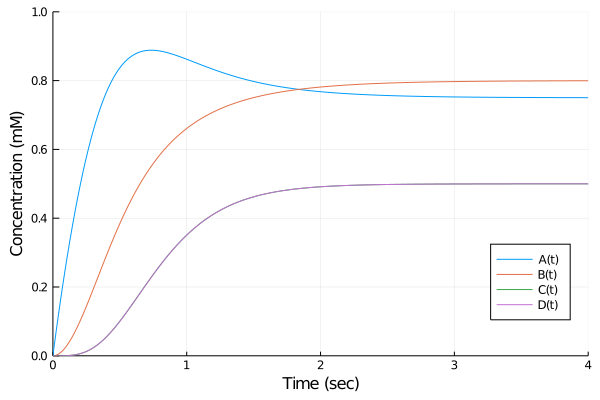

In [8]:
function fig_29(u, p, t)
    @unpack a, b, c, d = u
    v1 = 2.0a
    v2 = 2.5*a*b
    v3 = 3.0c
    v4 = 3.0d
    
    da = 3.0 - v1 - v2
    db = v1 - v2
    dc = v2 - v3
    dd = v2 - v4
    return [da, db, dc, dd]
end

u0 = zeros(4)
prob = ODEProblem(fig_29, u0, 10.0)
sol = solve(prob)

plot(sol, xlims=(0.0, 4.0), ylims=(0.0, 1.0), 
     xlabel="Time (sec)", ylabel="Concentration (mM)", 
     label=["A" "B" "C" "D"], legend=:bottomright)

# Figure 2.11-14 Model reduction

┌ Warning: The RegularJump interface has changed to be matrix-free. See the documentation for more details.
└ @ DiffEqJump C:\Users\TsengWen-Wei\.julia\packages\DiffEqJump\dTrZP\src\jumps.jl:43
┌ Warning: The RegularJump interface has changed to be matrix-free. See the documentation for more details.
└ @ DiffEqJump C:\Users\TsengWen-Wei\.julia\packages\DiffEqJump\dTrZP\src\jumps.jl:43
┌ Warning: The RegularJump interface has changed to be matrix-free. See the documentation for more details.
└ @ DiffEqJump C:\Users\TsengWen-Wei\.julia\packages\DiffEqJump\dTrZP\src\jumps.jl:43


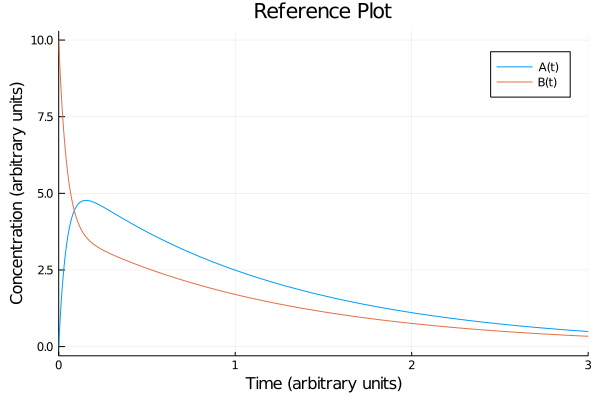

In [9]:
#=
Figure 2.11 (Fig 1) & Figure 2.12 (Fig 2)
Simulation and rapid equilibrium approximation
As well as figure 2.13 Rapid equilibrium approximation
=#

using DifferentialEquations, DiffEqBiological, Plots

originalRn = @reaction_network begin
    K0, 0 --> A
    K1, A --> B
    KM1, B --> A
    K2, B --> 0
end K0 K1 KM1 K2

reaRn = @reaction_network begin
    K0, 0 --> B
    K2 * K1 / (KM1 + K1), B --> 0
end K0 K1 KM1 K2

qssaRn = @reaction_network begin
    K0, 0--> B
    K2, B --> 0
end K0 K1 KM1 K2

tspan = (0.0, 3.0)
p = (K0=0, K1=9, KM1=12, K2=2)
u0 = [0.0, 10.0]

probOG = ODEProblem(originalRn, u0, tspan, p)
solOG = solve(probOG)

# Figure 2.11 (Fig 1)
plot(solOG, xlabel="Time (arbitrary units)", ylabel="Concentration (arbitrary units)", title="Reference Plot")

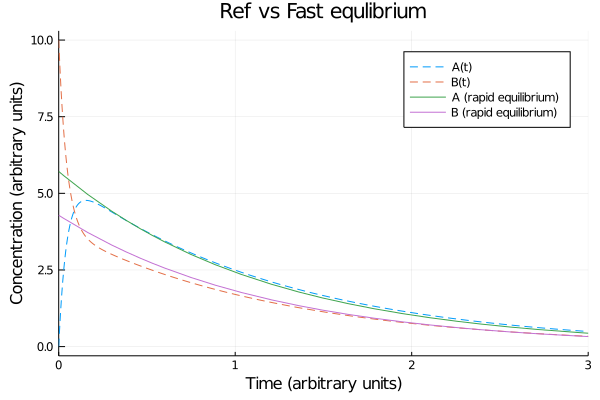

In [10]:
# Figure 2.12 (Fig 2)
plot(solOG, line=(:dash, 1), title="Ref vs Fast equlibrium", 
     xlabel="Time (arbitrary units)", ylabel="Concentration (arbitrary units)")

u0Rea = [sum(u0)]
probRea = ODEProblem(reaRn, u0Rea, tspan, p)
solRea = solve(probRea)

ϕA = p.KM1 / (p.KM1 + p.K1)
ϕB = 1 - ϕA

plot!(t-> ϕA * solRea(t)[1], tspan[1], tspan[2], lab="A (rapid equilibrium)")
plot!(t-> ϕB * solRea(t)[1], tspan[1], tspan[2], lab="B (rapid equilibrium)")

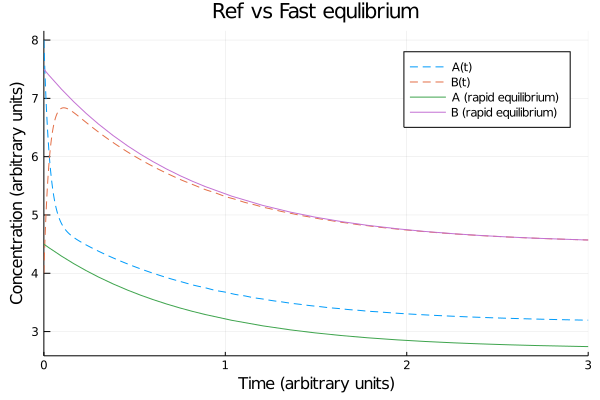

In [11]:
# Figure 2.13
p = (K0=9, K1=20, KM1=12, K2=2)
u0 = [8.0, 4.0]
tspan = (0.0, 3.0)
probOG = ODEProblem(originalRn, u0, tspan, p)
solOG = solve(probOG)

plot(solOG, line=(:dash, 1),
     xlabel="Time (arbitrary units)",
     ylabel="Concentration (arbitrary units)",
     title="Ref vs Fast equlibrium")

u0Rea = [sum(u0)]
probRea = ODEProblem(reaRn, u0Rea, tspan, p)
solRea = solve(probRea)

ϕA = p.KM1 / (p.KM1 + p.K1)
ϕB = 1 - ϕA

plot!(t-> ϕA * solRea(t)[1], tspan[1], tspan[2], lab="A (rapid equilibrium)")
plot!(t-> ϕB * solRea(t)[1], tspan[1], tspan[2], lab="B (rapid equilibrium)")

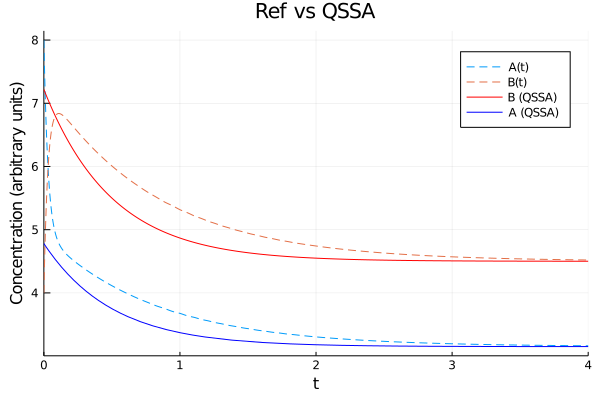

In [12]:
# Figure 2.14
tspan = (0.0, 4.0)
p = (K0=9, K1=20, KM1=12, K2=2)
u0 = [8.0, 4.0]
probOG = ODEProblem(originalRn, u0, tspan, p)
solOG = solve(probOG)

plot(solOG, line=(:dash, 1), xlims=tspan,
     xlabel="Time (arbitrary units)",
     ylabel="Concentration (arbitrary units)",
     title="Ref vs QSSA")

u0QSS = [(sum(u0) - p.K0 / p.K1) / (1 + p.KM1/p.K1)]
probQSSA = ODEProblem(qssaRn, u0QSS, tspan, p)
solQSSA = solve(probQSSA)

plot!(solQSSA, label="B (QSSA)", line=(1, :red))
# Plotting use the form plot(f, xmin, xmax, options)
_a(b) = (p.K0 + p.KM1 * b) / p.K1
plot!(t->_a(solQSSA(t)[1]), tspan[1], tspan[2], lab="A (QSSA)", line=(1, :blue))

# Problem 2.4.6

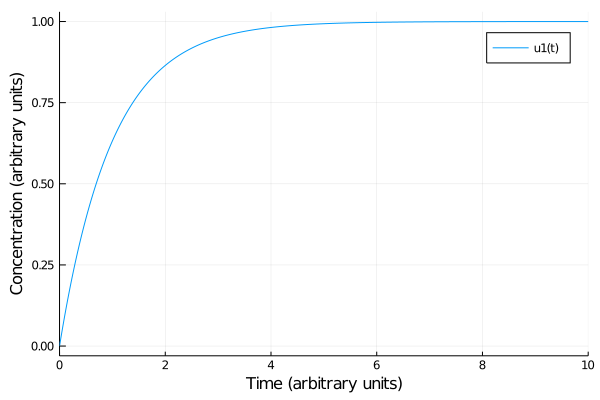

In [13]:
## Problem 2.4.6
f(u, p, t) = p * (1.0-u)
p = 1.0
u0 = 0.0
tspan = (0.0, 10.0)
prob = ODEProblem(f, u0, tspan, p)
sol = solve(prob)
plot(sol, xlabel="Time (arbitrary units)", ylabel="Concentration (arbitrary units)")

# Figure 3.03 Michaelis-Menten kinetics

┌ Warning: The RegularJump interface has changed to be matrix-free. See the documentation for more details.
└ @ DiffEqJump C:\Users\TsengWen-Wei\.julia\packages\DiffEqJump\dTrZP\src\jumps.jl:43
┌ Warning: The RegularJump interface has changed to be matrix-free. See the documentation for more details.
└ @ DiffEqJump C:\Users\TsengWen-Wei\.julia\packages\DiffEqJump\dTrZP\src\jumps.jl:43


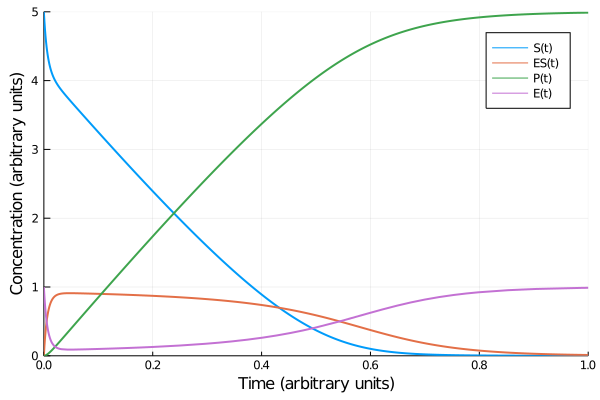

In [1]:
using DifferentialEquations, DiffEqBiological, Plots
Plots.gr(fmt=:png)

# S + E <-> ES complex -> P + E
mm_full = @reaction_network begin
    K1 * (ET - ES), S --> ES
    KM1, ES --> S
    K2, ES --> P
end ET K1 KM1 K2

mm_reduced = @reaction_network begin
  mm(S, K2 * ET, (KM1 + K2) / K1)  , S ⇒ 0
end ET K1 KM1 K2

# Plot full model
p = (ET = 1.0, K1 = 30.0, KM1=1.0, K2=10.0)
u0 = [5.0, 0.0, 0.0]
tspan = (0.0, 1.0)
probfull = ODEProblem(mm_full, u0, tspan, p)
solFull = solve(probfull)
plot(solFull, lw=2, xlabel="Time (arbitrary units)",
     ylabel="Concentration (arbitrary units)",
     xlims=(0.0,1.0), ylims=(0.0,5.0))
plot!(t-> p.ET - solFull(t)[2], tspan[1], tspan[2], label="E(t)", lw=2)

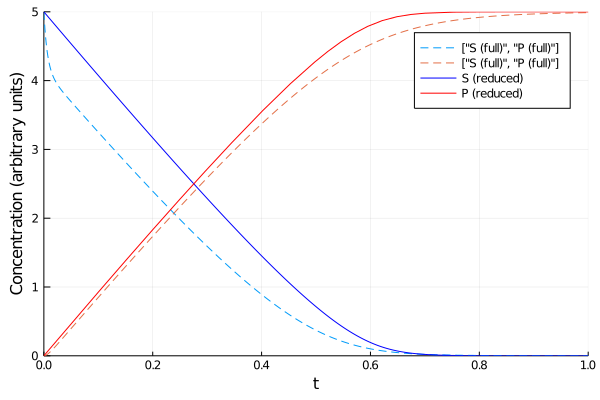

In [2]:
# Run reduced model
u0 = [5.0]
probRed = ODEProblem(mm_reduced, u0, tspan, p)
solRed = solve(probRed)

plot(xlabel="Time (arbitrary units)",
     ylabel="Concentration (arbitrary units)",
     xlims=(0.0,1.0), ylims=(0.0,5.0))

plot!(solFull, vars=(0, [1, 3]), line=(:dash, 1), label=["S (full)", "P (full)"])
plot!(solRed, line=(1, :blue), lab="S (reduced)")
plot!(t -> u0[1] - solRed(t)[1], tspan[1], tspan[2], line=(1, :red), lab="P (reduced)")

# Fig 3.13 Comparions of GMA and Michaelis-Menten rate laws

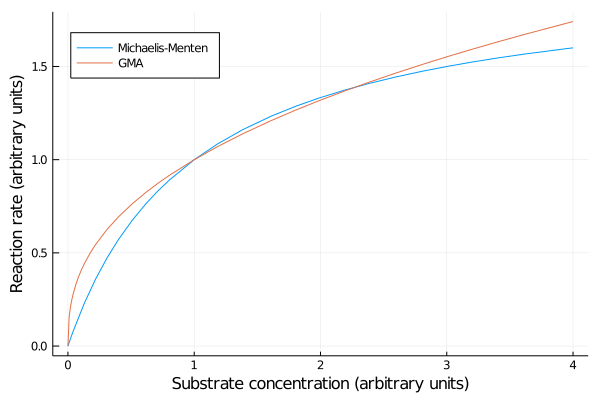

In [3]:
using DifferentialEquations, Plots
Plots.gr(fmt=:png)

plot(xlabel="Substrate concentration (arbitrary units)",
     ylabel="Reaction rate (arbitrary units)",
     legend = :topleft)
plot!(t -> 2 * t / (1 + t), 0.0, 4.0, lab="Michaelis-Menten")
plot!(t -> t^0.4, 0.0, 4.0, lab="GMA")

# Problem 3.7.5

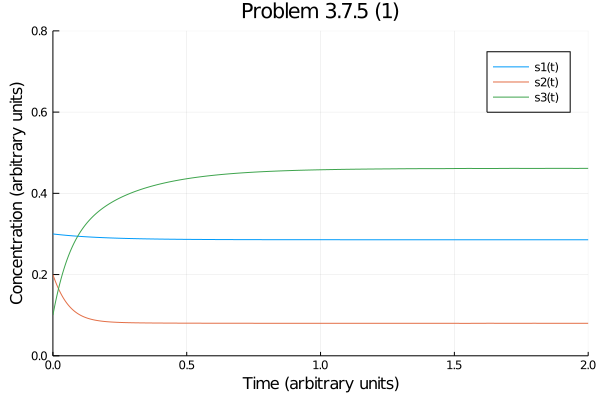

In [4]:
using DifferentialEquations, Plots, Parameters, LabelledArrays
Plots.gr(fmt=:png)

_mm(x, k) = x / (x + k)
_v_full(vmax, s, km) = vmax * _mm(s, km) 
_v_reduced(vmax, s, km) = vmax * s / km

@with_kw struct ChainParams
    V0 = 2.0
    VM1 = 9.0
    VM2 = 12.0
    VM3 = 15.0
    KM1 = 1.0
    KM2 = 0.4
    KM3 = 3.0
    _v = _v_full
end

function model!(du, u, p::ChainParams, t)
    @unpack V0, VM1, VM2, VM3, KM1, KM2, KM3, _v = p
    s1, s2, s3 = u.s1, u.s2, u.s3
    v1 = _v(VM1, s1, KM1)
    v2 = _v(VM2, s2, KM2)
    v3 = _v(VM3, s3, KM3)
    du.s1 = V0 - v1
    du.s2 = v1 - v2
    du.s3 = v2 - v3
    return du
end

# first set of ICs
tspan = (0.0, 2.0)
u0 = LVector(s1=0.3, s2=0.2, s3=0.1)
prob1 = ODEProblem(model!, u0, tspan, ChainParams())
sol1 = solve(prob1)
plot(sol1, lw=1, xlims=tspan, ylims=(0.0, 0.8),
     title="Problem 3.7.5 (1)",
     xlabel="Time (arbitrary units)",
     ylabel="Concentration (arbitrary units)")

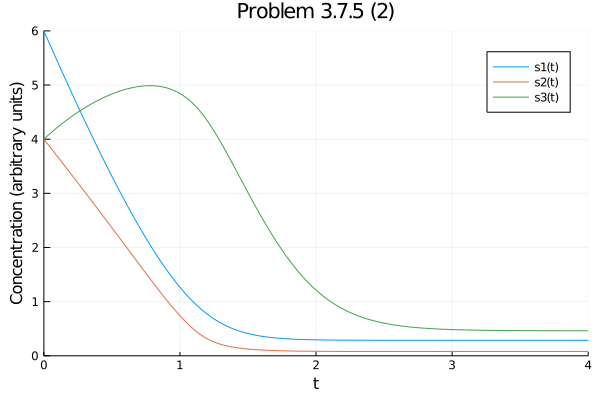

In [5]:
# second set of ICs
u0 = LVector(s1=6.0, s2=4.0, s3=4.0)
tspan = (0.0, 4.0)
prob2 = ODEProblem(model!, u0, tspan, ChainParams())
sol2 = solve(prob2)
plot(xlims=tspan, ylims=(0.0, 6.0),
     title="Problem 3.7.5 (2)",
     xlabel="Time (arbitrary units)",
     ylabel="Concentration (arbitrary units)")
plot!(sol2, lw=1)

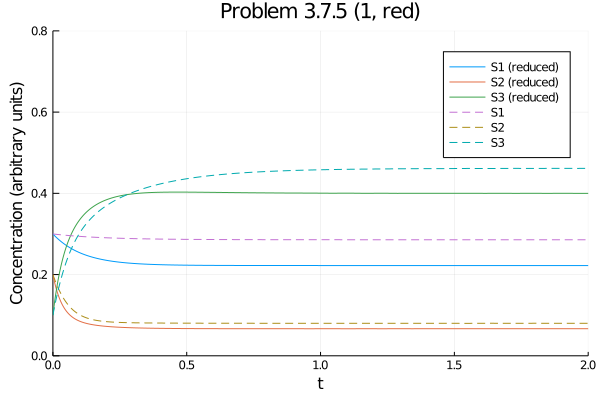

In [6]:
tspan = (0.0, 2.0)
u0 = LVector(s1=0.3, s2=0.2, s3=0.1)
prob_red = ODEProblem(model!, u0, tspan, ChainParams(_v=_v_reduced))
sol1_red = solve(prob_red)
plot(xlims=tspan, ylims=(0.0, 0.8),
     title="Problem 3.7.5 (1, red)",
     xlabel="Time (arbitrary units)",
     ylabel="Concentration (arbitrary units)")
plot!(sol1_red, lw=1, labels=["S1 (reduced)" "S2 (reduced)" "S3 (reduced)"])
plot!(sol1, lw=1, labels=["S1 " "S2 " "S3 "], ls=:dash)

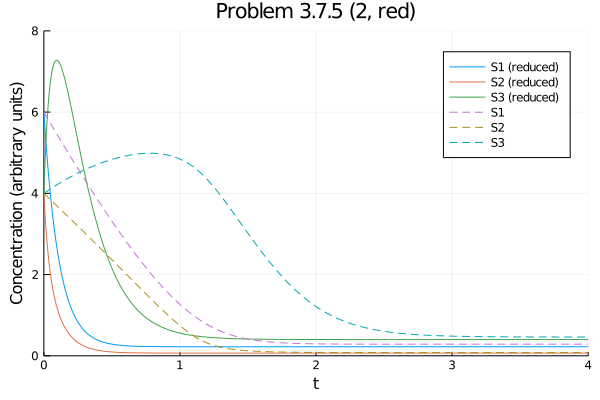

In [7]:
# second set of ICs, reduced model
tspan = (0.0, 4.0)
u0 = LVector(s1=6.0, s2=4.0, s3=4.0)
prob2 = ODEProblem(model!, u0, tspan, ChainParams(_v=_v_reduced))
sol2_red = solve(prob2)

plot(xlims=tspan, ylims=(0.0, 8.00),
     title="Problem 3.7.5 (2, red)",
     xlabel="Time (arbitrary units)",
     ylabel="Concentration (arbitrary units)")
plot!(sol2_red, lw=1, labels=["S1 (reduced)" "S2 (reduced)" "S3 (reduced)"])
plot!(sol2, lw=1, labels=["S1 " "S2 " "S3 "], ls=:dash)

# Figure 4.1, 4.2, 4.3, 4.4A, 4.5, and 4.18

In [2]:
using DifferentialEquations, DiffEqBiological, PyPlot, LinearAlgebra

rn = @reaction_network begin
  hillr(B, K1, 1, N), 0 --> A
  K2, 0 --> B
  K5, A --> B
  K4, B --> 0
  K3, A --> 0
end K1 K2 K3 K4 K5 N

tspan = (0.0, 1.5)
p = (K1=20.0, K2=5.0, K3=5.0, K4=5.0, K5=2.0, N=4.0)
u0s = [[0, 0], [0.5, 0.6], [0.17, 1.1], [0.25, 1.9], [1.85, 1.7]]

sols = [solve(ODEProblem(rn, u0, tspan, p)) for u0 in u0s];

┌ Warning: The RegularJump interface has changed to be matrix-free. See the documentation for more details.
└ @ DiffEqJump C:\Users\TsengWen-Wei\.julia\packages\DiffEqJump\dTrZP\src\jumps.jl:43


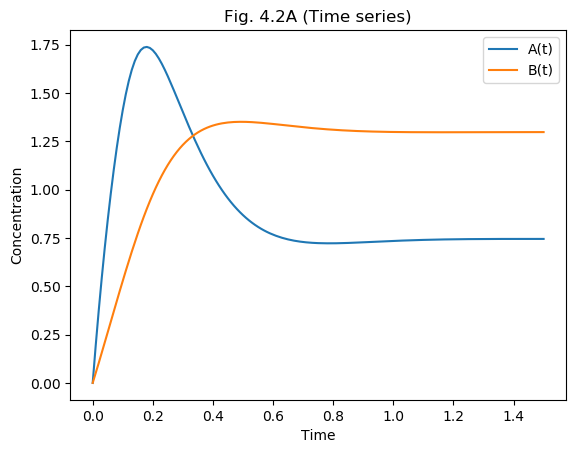

PyObject Text(24.000000000000007, 0.5, 'Concentration')

In [3]:
# Fig. 4.2A (Time series)
figure()
ts = tspan[1]:0.01:tspan[2]
a = sols[1](ts, idxs=1)
b = sols[1](ts, idxs=2)

title("Fig. 4.2A (Time series)")
plot(ts, a, label="A(t)")
plot(ts, b, label="B(t)")
legend(["A(t)", "B(t)"])
xlabel("Time")
ylabel("Concentration")

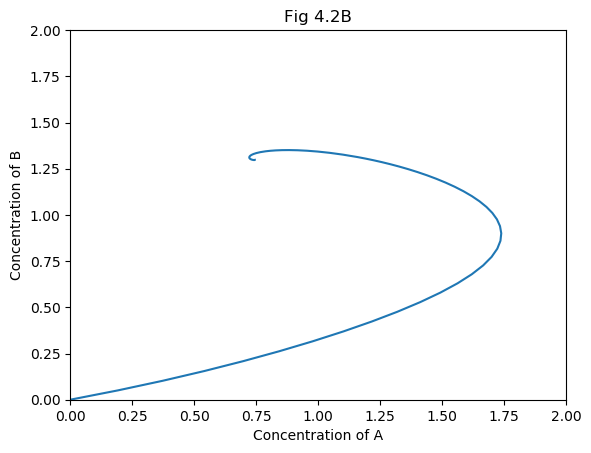

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000010DAD88>

In [4]:
# Fig. 4.2B (Phase portrait)
figure()
title("Fig 4.2B")
xlim(0, 2)
ylim(0, 2)
xlabel("Concentration of A")
ylabel("Concentration of B")
plot(a, b)

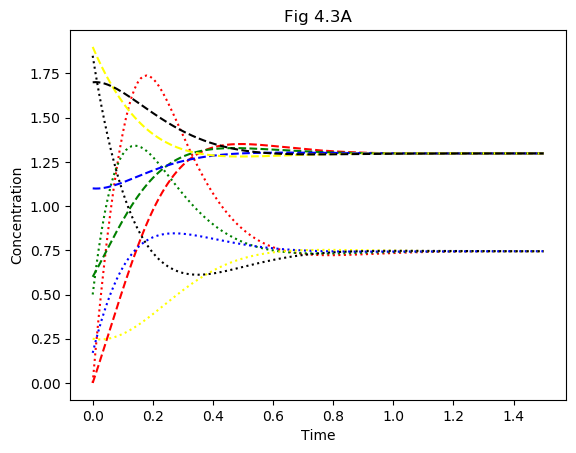

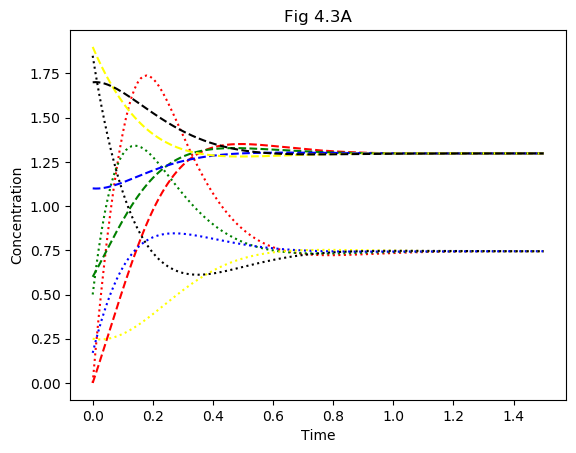

In [5]:
# Fig. 4.3A (Multiple time series)
figure()
cs = ["red", "green", "blue", "yellow", "black"]
title("Fig 4.3A")
xlabel("Time")
ylabel("Concentration")
for (sol, c) in zip(sols, cs)
    a = sol(ts, idxs=1)
    b = sol(ts, idxs=2)
    plot(ts, a, c, linestyle=":")
    plot(ts, b, c, linestyle="--")
end
gcf()

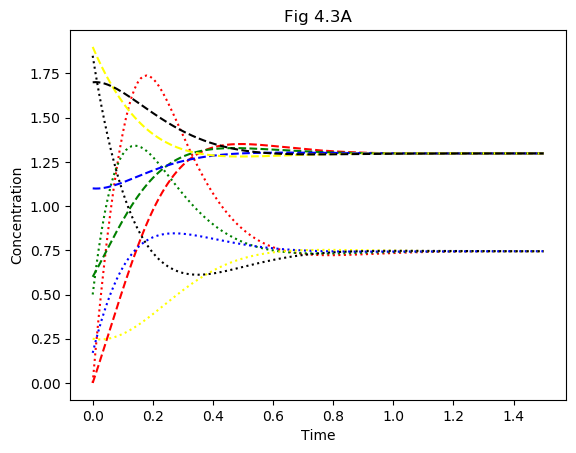

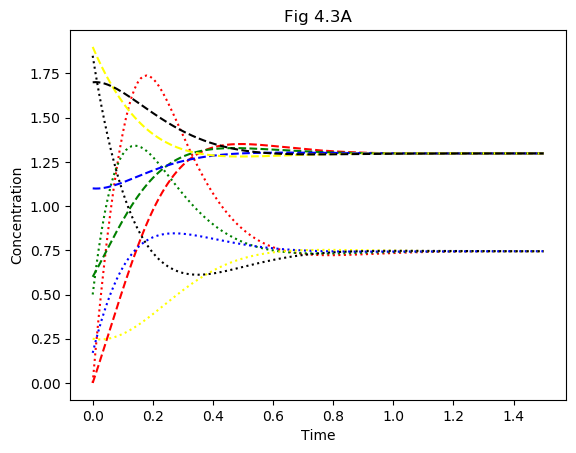

In [6]:
# Fig. 4.3A (Multiple time series)
figure()
cs = ["red", "green", "blue", "yellow", "black"]
title("Fig 4.3A")
xlabel("Time")
ylabel("Concentration")
for (sol, c) in zip(sols, cs)
    a = sol(ts, idxs=1)
    b = sol(ts, idxs=2)
    plot(ts, a, c, linestyle=":")
    plot(ts, b, c, linestyle="--")
end
gcf()

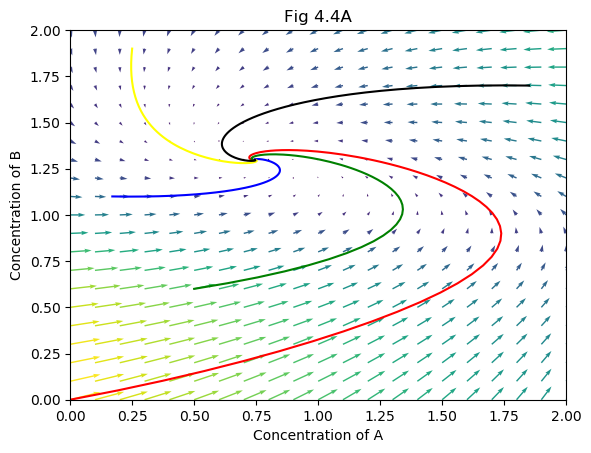

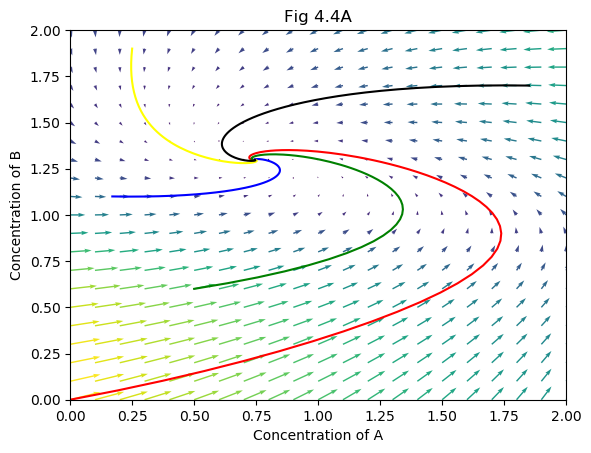

In [7]:
# Figure 4.4A
# Add vector field to Fig. 4.3B
figure()
title("Fig 4.4A")
xlabel("Concentration of A")
ylabel("Concentration of B")
lb, ub = 0.0, 2.0
xlim(lb, ub)
ylim(lb, ub)
for (sol, c) in zip(sols, cs)
    a = sol(ts, idxs=1)
    b = sol(ts, idxs=2)
    plot(a, b, color=c)
end
xrange = yrange = lb:0.1:ub
V = [rn([x, y], p, 0.0) for y in yrange, x in xrange]
u = getindex.(V, 1)
v = getindex.(V, 2)
quiver(xrange, yrange, u, v, hypot.(u, v))
gcf()

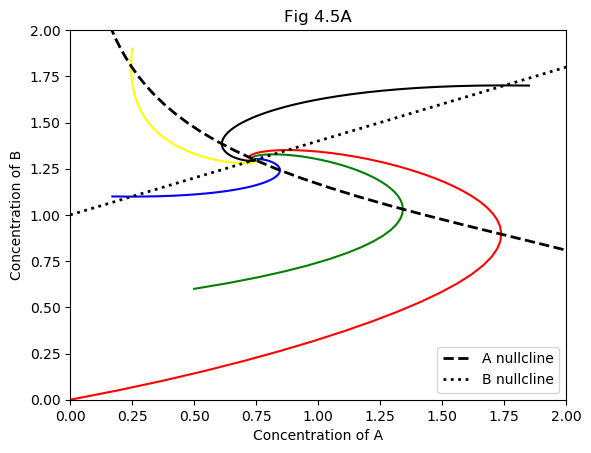

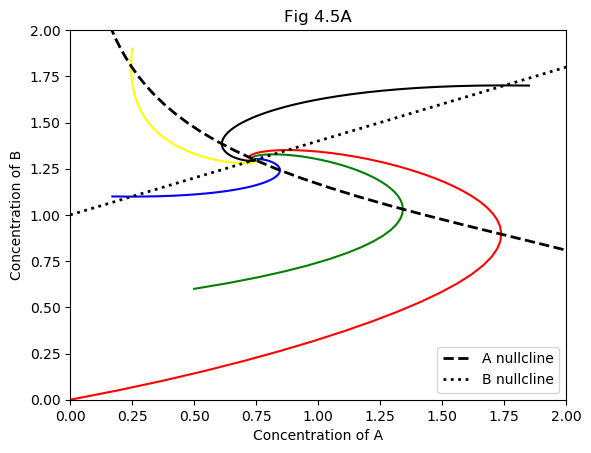

In [8]:
# Figure 4.5A
# nullclines
figure()
title("Fig 4.5A")
xlabel("Concentration of A")
ylabel("Concentration of B")
xlim(lb, ub)
ylim(lb, ub)
for (sol, c) in zip(sols, cs)
    a = sol(ts, idxs=1)
    b = sol(ts, idxs=2)
    PyPlot.plot(a, b, color=c)
end
# nullclines (ds/dt = 0)
ns12 = 0.0:0.05:2
ns11 = @. p.K1 / ((p.K3 + p.K5) * (1 + ns12^p.N))
ns21 = 0.0:0.05:2
ns22 = @. (p.K2 + p.K5 * ns21) / p.K4
plot(ns11, ns12, "k--", label="A nullcline", linewidth=2)
plot(ns21, ns22, "k:", label="B nullcline", linewidth=2)
legend(loc="best")
gcf()

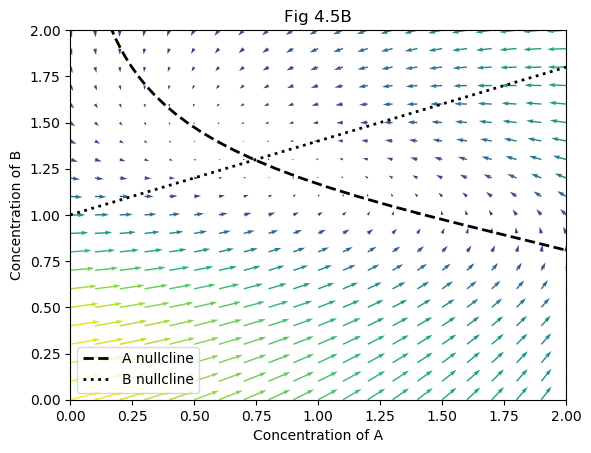

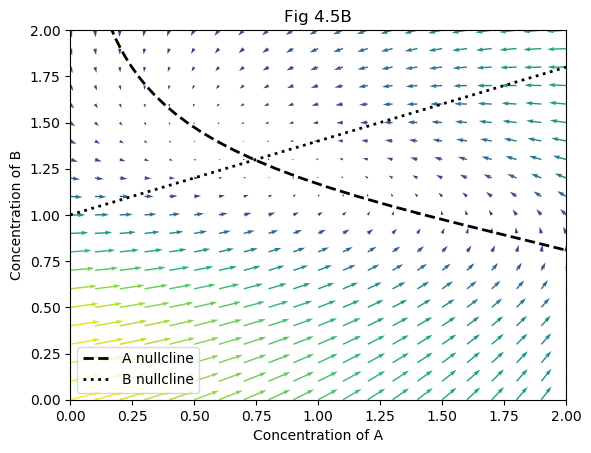

In [9]:
# Figure 4.5B
figure()
title("Fig 4.5B")
xlabel("Concentration of A")
ylabel("Concentration of B")
xlim(lb, ub)
ylim(lb, ub)
quiver(xrange, yrange, u, v, hypot.(u, v))
plot(ns11, ns12, "k--", label="A nullcline", linewidth=2)
plot(ns21, ns22, "k:", label="B nullcline", linewidth=2)
legend(loc="best")
gcf()

┌ Warning: Attribute alias `xlabel` detected in the user recipe defined for the signature (::DiffEqBiological.BifurcationDiagram). To ensure expected behavior it is recommended to use the default attribute `xguide`.
└ @ Plots C:\Users\TsengWen-Wei\.julia\packages\Plots\JKY3H\src\pipeline.jl:15
┌ Warning: Attribute alias `color` detected in the user recipe defined for the signature (::DiffEqBiological.BifurcationPath, ::Int64). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\TsengWen-Wei\.julia\packages\Plots\JKY3H\src\pipeline.jl:15


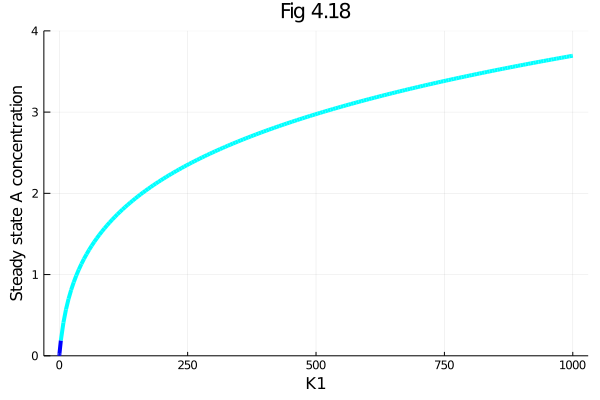

In [10]:
# Figure 4.18. Continuation plot
# N simulations to steady state for different values of K1
bif = bifurcations(rn, collect(p), :K1, (0.0, 1000.0))
using Plots
Plots.gr(fmt=:png)
Plots.plot(bif)
Plots.plot!(ylabel="Steady state A concentration", title="Fig 4.18", ylims=(0.0,4.0))